<a href="https://colab.research.google.com/github/Topofajar/Travt_Recommendation-System/blob/main/ML_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Import libraries
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [2]:
# Load datasets
tourist_resto_data = pd.read_csv("https://raw.githubusercontent.com/Topofajar/Travt_Recommendation-System/main/Dataset/Tourist%20and%20Resto%20Data.csv")
rating_data = pd.read_csv("https://raw.githubusercontent.com/Topofajar/Travt_Recommendation-System/main/Dataset/Rating%20Data.csv")
user_data = pd.read_csv("https://raw.githubusercontent.com/Topofajar/Travt_Recommendation-System/main/Dataset/User%20Data.csv")


In [3]:
# Check columns
print("Tourist and Resto Data columns:", tourist_resto_data.columns)
print("Rating Data columns:", rating_data.columns)
print("User Data columns:", user_data.columns)

Tourist and Resto Data columns: Index(['place_id', 'place_maps_id', 'name', 'site', 'subtypes', 'category',
       'phone', 'full_address', 'city', 'latitude', 'longitude', 'location',
       'rating', 'total rating', 'reviews_link', 'rating_per_score_1',
       'rating_per_score_2', 'rating_per_score_3', 'rating_per_score_4',
       'rating_per_score_5', 'photos_count', 'photo 1', 'photo 2', 'photo 3',
       'photo 4', 'working_hours', 'about', 'description', 'verified',
       'location_link', 'reviews_id'],
      dtype='object')
Rating Data columns: Index(['user_id', 'place_id', 'rating', 'review'], dtype='object')
User Data columns: Index(['user_id', 'location', 'age', 'gender'], dtype='object')


In [4]:
# Ensure columns are correctly named
if 'place_id' in tourist_resto_data.columns:
    tourist_resto_data.rename(columns={'place_id': 'place_id'}, inplace=True)

# Merge datasets
merged_data = pd.merge(rating_data, tourist_resto_data, on='place_id')
merged_data = pd.merge(merged_data, user_data, on='user_id')

# Select relevant columns
merged_data = merged_data[['user_id', 'place_id', 'rating_x', 'latitude', 'longitude']]

# Rename columns for clarity
merged_data.columns = ['user_id', 'place_id', 'rating', 'latitude', 'longitude']

# Create mappings for user and place IDs
user_id_map = {id_: i for i, id_ in enumerate(merged_data['user_id'].unique())}
place_id_map = {id_: i for i, id_ in enumerate(merged_data['place_id'].unique())}

# Map user and place IDs to integers
merged_data['user_id'] = merged_data['user_id'].map(user_id_map)
merged_data['place_id'] = merged_data['place_id'].map(place_id_map)

# Split data into training and testing sets
train, test = train_test_split(merged_data, test_size=0.2, random_state=42)

# Number of unique users and places
n_users = len(user_id_map)
n_places = len(place_id_map)

print('n_users', n_users)
print('n_places', n_places)

n_users 27499
n_tplaces 742


In [5]:
# Define input layers
user_input = Input(shape=(1,), name='user_input')
place_input = Input(shape=(1,), name='place_input')

# User and place embeddings
user_embedding = Embedding(output_dim=50, input_dim=n_users, input_length=1)(user_input)
place_embedding = Embedding(output_dim=50, input_dim=n_places, input_length=1)(place_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
place_flat = Flatten()(place_embedding)

# Concatenate user and place embeddings
concat = Concatenate()([user_flat, place_flat])

# BatchNormalization
batch_norm = BatchNormalization()(concat)

# Dense layers with L2 regularization
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(batch_norm)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

In [6]:
# Model
model = Model(inputs=[user_input, place_input], outputs=output)

# Compile model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                1374950   ['user_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                37100     ['place_input[0][0]']         
                                                                                              

In [7]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        training_loss = logs.get('loss')
        validation_loss = logs.get('val_loss')

        # Check if training loss is better than validation loss
        if training_loss and validation_loss and training_loss <= validation_loss:
            print(f'\nEpoch {epoch + 1}: Training loss {training_loss} is better than validation loss {validation_loss}.')
        else:
            print(f'\nEpoch {epoch + 1}: Training loss {training_loss} is NOT better than validation loss {validation_loss}.')

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
custom_callback = CustomCallback()

# Fit the model
history = model.fit([train.user_id, train.place_id], train.rating,
                    epochs=50, batch_size=128,
                    validation_data=([test.user_id, test.place_id], test.rating),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
3823/3823 [==============================] - ETA: 0s - loss: 1.8059
Epoch 1: val_loss improved from inf to 0.83470, saving model to best_model.h5
3823/3823 [==============================] - 46s 9ms/step - loss: 1.8059 - val_loss: 0.8347
Epoch 2/50
   9/3823 [..............................] - ETA: 26s - loss: 1.1176

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3816/3823 [============================>.] - ETA: 0s - loss: 0.9367
Epoch 2: val_loss improved from 0.83470 to 0.82443, saving model to best_model.h5
3823/3823 [==============================] - 25s 7ms/step - loss: 0.9365 - val_loss: 0.8244
Epoch 3/50
3820/3823 [============================>.] - ETA: 0s - loss: 0.8377
Epoch 3: val_loss improved from 0.82443 to 0.82310, saving model to best_model.h5
3823/3823 [==============================] - 22s 6ms/step - loss: 0.8376 - val_loss: 0.8231
Epoch 4/50
3820/3823 [============================>.] - ETA: 0s - loss: 0.8139
Epoch 4: val_loss did not improve from 0.82310
3823/3823 [==============================] - 23s 6ms/step - loss: 0.8139 - val_loss: 0.8271
Epoch 5/50
3823/3823 [==============================] - ETA: 0s - loss: 0.8023
Epoch 5: val_loss did not improve from 0.82310
3823/3823 [==============================] - 23s 6ms/step - loss: 0.8023 - val_loss: 0.8364
Epoch 6/50
3823/3823 [==============================] - ETA: 0s - los

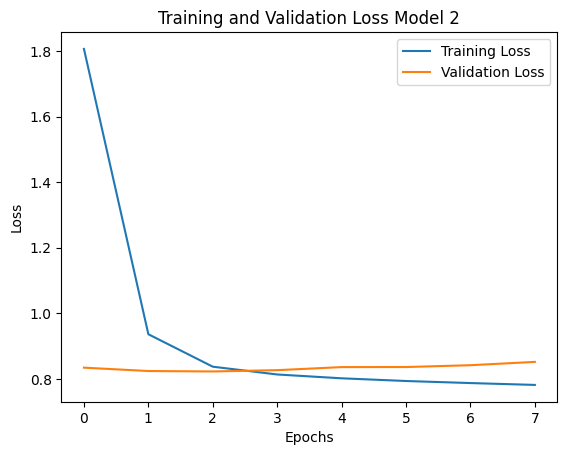

In [8]:
import matplotlib.pyplot as plt

# Plot training loss starting from epoch 3
plt.plot(history.epoch, history.history['loss'], label='Training Loss')

# Plot validation loss starting from epoch 3
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Model 2")

# Adding legend
plt.legend()

# Show the plot
plt.show()
